In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from gensim.models import Word2Vec
# from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

Dataset: https://www.kaggle.com/kazanova/sentiment140

In [2]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", header=None, encoding = "ISO-8859-1")
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

In [3]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
# Select equal number of positives and negatives
SIZE = 1_000_000
HALF = df.shape[0]//2
df = df[HALF-SIZE//2 : HALF + SIZE//2]
df = df[['target', 'text']]

# Convert 4 (positive sentiment) to 1
df['target'].loc[df['target']==4]=1

In [5]:
df['target'].value_counts()

0    500000
1    500000
Name: target, dtype: int64

#### Preprocessing:

From: https://github.com/francisbautista/cs174/blob/master/Notebooks/L04%20-%20Word2Vec.ipynb

In [6]:
stop = set(stopwords.words('english'))
negation = {"arent", "didnt", "doesnt", "dont", "isnt", 'no', 'not', "wasnt", "couldnt", "werent", "shouldnt", "mightnt", "shouldnt"}
stop = stop - negation

def preprocess(text):
    text=text.lower()
    text=re.sub('[^0-9a-z]+',' ',text)
    split = text.split()
    stopped = [i for i in split if i not in stop]
    return(stopped)

In [7]:
df['text'] = df['text'].apply(preprocess)

#### Find word embeddings with Word2Vec

In [8]:
model = Word2Vec(vector_size=100,window=5,min_count=30, sg=0, alpha = 0.025)
model.build_vocab(df['text'])

In [9]:
model.train(df['text'], total_examples=model.corpus_count, epochs=20)

(129076790, 159822620)

In [10]:
model.wv['test']

array([-1.458461  , -1.0490386 , -0.36907503, -0.41047382,  1.0222993 ,
        0.2791059 ,  1.6138996 , -1.2785671 ,  1.0478672 ,  0.57160795,
        2.0259926 , -1.517303  ,  0.5887529 ,  0.8480127 ,  0.21396309,
       -2.1308403 ,  0.21341072, -1.6358969 ,  2.3191242 ,  2.3746486 ,
       -0.42181635,  1.7573304 , -1.111119  ,  0.59351957,  0.15789953,
       -0.2327465 , -2.0046015 ,  0.0714898 ,  0.27155408, -0.84404284,
       -0.52713525, -1.6555046 ,  1.4264748 , -1.6620305 , -2.3807256 ,
       -0.10868134,  1.439591  ,  0.27008477,  4.0741167 , -2.380836  ,
        1.8581498 ,  1.7597046 , -0.99402887, -0.6071083 , -0.4343107 ,
       -0.07155914,  2.2356493 ,  1.6671185 ,  0.8967986 ,  3.6181376 ,
        0.17884342, -0.9947086 , -0.36112237,  0.47174466, -0.92439556,
       -0.47028798,  1.9002432 , -2.7159307 ,  2.4127095 ,  0.8648189 ,
        1.2864494 , -0.5165195 , -0.09358399,  2.6398926 , -0.69862443,
        0.7661021 , -0.40753338, -3.0880566 , -0.52926356, -2.41

In [11]:
model.wv.most_similar('test')

[('exam', 0.7885432839393616),
 ('tests', 0.7443763017654419),
 ('regents', 0.7380606532096863),
 ('midterm', 0.6947118043899536),
 ('math', 0.6762940883636475),
 ('calculus', 0.6719021797180176),
 ('biology', 0.6690829396247864),
 ('calc', 0.6648274064064026),
 ('physics', 0.6648216843605042),
 ('gcse', 0.6635955572128296)]

#### Get avg. vector for each tweet

In [12]:
# http://yaronvazana.com/2018/09/20/average-word-vectors-generate-document-paragraph-sentence-embeddings/

def get_avg_vec(list_of_words, model=None):
    words = [word for word in list_of_words if word in model.wv]
    
    if len(words) > 0:
        res = np.mean(model.wv[words], axis=0)
    else:
        res = np.zeros(model.vector_size)
    return res

In [13]:
df['avg_vec'] = df['text'].apply(get_avg_vec, model=model)

In [14]:
df.reset_index(drop=True, inplace=True)
df

,target,text,avg_vec
0,0,"[tuquyenmach, sasha, probably]","[0.20705336, 0.16301805, -0.10401443, -0.71160..."
1,0,"[ohhh, logan, gov, site, look, new, dogs, pound]","[-0.39543203, -0.03729804, -0.07928294, 0.0141..."
2,0,"[loved, trailer, waas, great, great, great, wo...","[0.10155979, -1.1548122, 0.26084587, -0.031069..."
3,0,"[tthompson1969, f, er, see, stay, away, cesspi...","[-0.75571346, 0.3058267, 0.4744431, 0.13318528..."
4,0,"[today, el, salvador, swore, first, far, left,...","[-0.9282821, -0.38437146, -0.17503935, -0.1125..."
...,...,...,...
999995,1,"[watching, horton, hears, tasha, apartment]","[0.46412435, -0.3430474, 0.55459565, 0.0192161..."
999996,1,"[shama, r, u, friendfeed, got, friend, request...","[-0.080343485, -0.56498766, 0.44686127, -0.214..."
999997,1,"[shinepetphotos, thanks, comments, grace, reco...","[-0.0982476, -0.27030215, -0.02498053, 0.61749..."
999998,1,"[looking, launch, unique, art, web, store, uni...","[0.7315175, -0.538476, 0.48641142, 0.3159832, ..."


#### Split into train, test, validation sets

* 70% = training
* 15% = test
* 15% = validation

Shuffle the dataset:

In [19]:
df_shuffled = df.sample(frac=1)
df_shuffled.reset_index(inplace=True, drop=True)

In [20]:
train_set = df_shuffled.iloc[:700_000]
test_set = df_shuffled.iloc[700_000:850_000]
val_set = df_shuffled.iloc[850_000:]

X_train = train_set['avg_vec'].to_numpy().reshape(-1, 1)
y_train = train_set['target'].to_numpy()

X_test = test_set['avg_vec'].to_numpy().reshape(-1, 1)
y_test = test_set['target']

X_val = val_set['avg_vec'].to_numpy().reshape(-1, 1)
y_val = val_set['target']

In [21]:
X_train = np.concatenate(np.concatenate(X_train, axis=0), axis=0).reshape(-1, 100)
X_test = np.concatenate(np.concatenate(X_test, axis=0), axis=0).reshape(-1, 100)
X_val = np.concatenate(np.concatenate(X_val, axis=0), axis=0).reshape(-1, 100)

In [22]:
X_train.shape

(700000, 100)

#### Classify with RandomForest

In [23]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier()

In [24]:
pred = forest.predict(X_test)

In [25]:
pd.Series(pred).value_counts()

0    76553
1    73447
dtype: int64

In [26]:
sum(pred == np.array(y_test)) / len(y_test)

0.7422066666666667

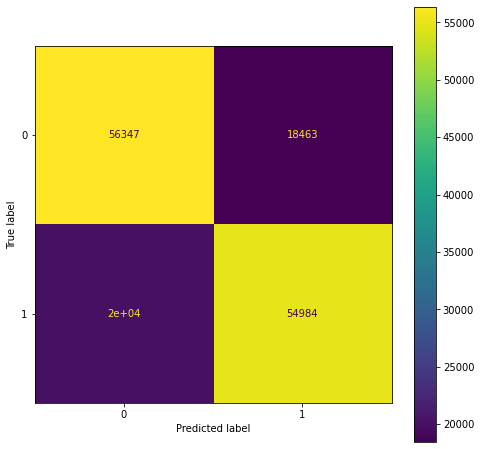

In [27]:
X_fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(forest, X_test, y_test, ax=ax)
plt.show()

### Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [33]:
pred = logreg.predict(X_test)

In [35]:
pd.Series(pred).value_counts()

1    75330
0    74670
dtype: int64

In [36]:
sum(pred == np.array(y_test)) / len(y_test)

0.7492666666666666

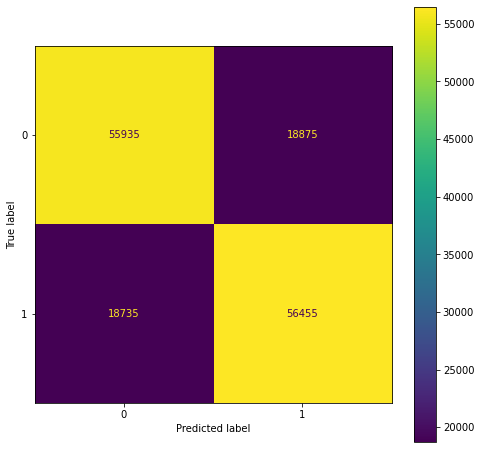

In [38]:
X_fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(logreg, X_test, y_test, ax=ax)
plt.show()